Python environment

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [ ]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scvi
import hotspot

In [ ]:
sc.settings.n_jobs = 8

In [ ]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [ ]:
import matplotlib as mpl
# https://github.com/theislab/scanpy/issues/1720
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

### Read pre-processed data

In [ ]:
tmp = sc.read('data/core_GBmap.h5ad')

# filter the myeloid population
cells = pd.read_csv('data/filtered_myeloid.csv')
tmp.obs['cells'] = tmp.obs.index.values
adata = tmp[tmp.obs['cells'].isin(cells['cells'].values.tolist())].copy()
print(adata)

In [ ]:
adata.layers["counts"] = adata.X.copy()

In [ ]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1000,
    batch_key="author",
    layer="counts",
    subset=True)

### Create SCVI model and train it on reference dataset

In [ ]:
sca.dataset.setup_anndata(adata, layer = 'counts', batch_key="author")

In [ ]:
vae = sca.models.SCVI(
    adata,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
    use_cuda = True # indicate to use gpu!
)

In [ ]:
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 10,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}
vae.train(n_epochs=500, frequency=1, early_stopping_kwargs=early_stopping_kwargs)

INFO     Training for 500 epochs                                                             
INFO     KL warmup for 400 epochs                                                            
Training...:  57%|█████▋    | 286/500 [2:02:41<40:48, 11.44s/it]INFO                                                                                         
         Stopping early: no improvement of more than 0 nats in 10 epochs                     
INFO     If the early stopping criterion is too strong, please instantiate it with different 
         parameters in the train method.                                                     
Training...:  57%|█████▋    | 286/500 [2:02:52<1:31:56, 25.78s/it]
INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training time:  4353 s. / 500 epochs                                                


In [ ]:
reference_latent = sc.AnnData(vae.get_latent_representation())

In [ ]:
sc.pp.neighbors(reference_latent, n_neighbors=8)
sc.tl.leiden(reference_latent, resolution = 1)
sc.tl.umap(reference_latent)

In [ ]:
reference_latent.obsm['X_scVI'] = vae.get_latent_representation()

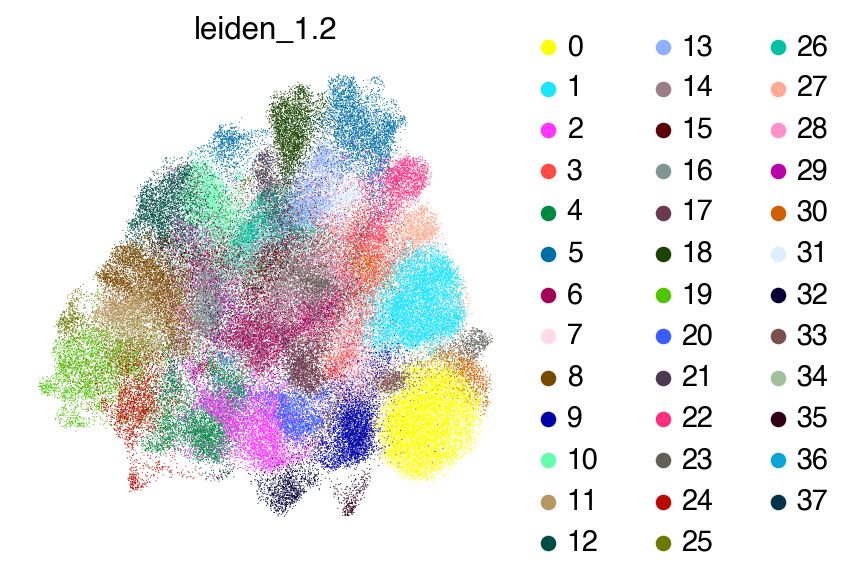

In [ ]:
sc.tl.leiden(reference_latent, resolution = 1.2, key_added= 'leiden_1.2')
sc.pl.umap(reference_latent,
           color=['leiden_1.2'],
           frameon=False,
           wspace=0.6,
           )

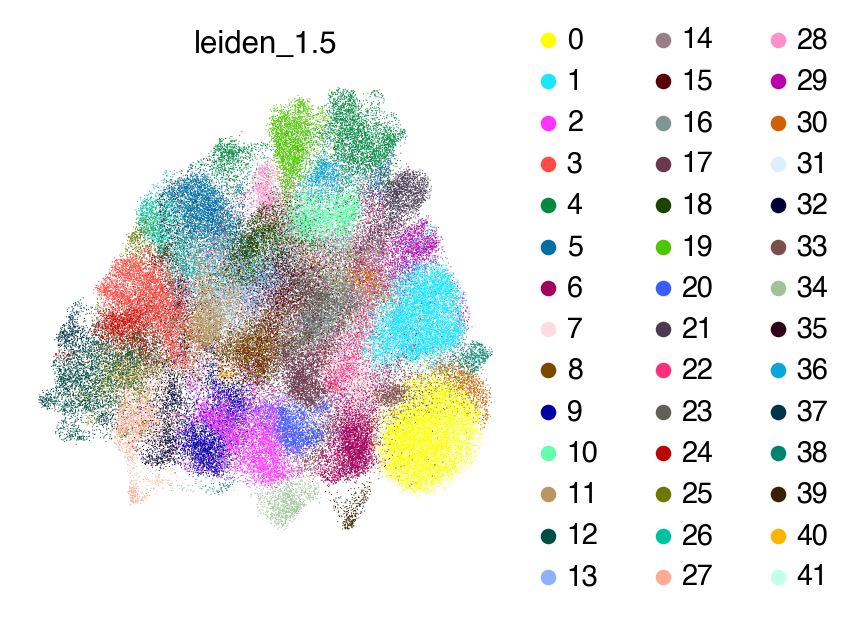

In [ ]:
sc.tl.leiden(reference_latent, resolution = 1.5, key_added= 'leiden_1.5')
sc.pl.umap(reference_latent,
           color=['leiden_1.5'],
           frameon=False,
           wspace=0.6,
           )

In [ ]:
reference_latent.write_h5ad('data/myeloid_SCVI_1000hvg.5had')

In [ ]:
latent = vae.get_latent_representation()
counts = pd.DataFrame(adata.layers['counts'].astype('float64').todense().transpose(), columns=adata.obs.index.values, 
                      index=adata.var_names)
scvi_data = pd.DataFrame(latent,index=adata.obs.index.values)

### Creating the Hotspot object

In [ ]:
# Create the Hotspot object and the neighborhood graph
hs = hotspot.Hotspot(counts, model='danb', latent=scvi_data)

In [ ]:
hs.create_knn_graph(
    weighted_graph=False, n_neighbors=30,
)

### Determining informative genes

In [ ]:
hs_results = hs.compute_autocorrelations(jobs=18)

hs_results.head(15)

100%|██████████| 1000/1000 [00:20<00:00, 49.61it/s]


,C,Z,Pval,FDR
Gene,,,,
HBA2,0.692414,44625.348703,0.0,0.0
HBB,0.599636,32857.392887,0.0,0.0
KCNQ1OT1,0.334632,28830.067881,0.0,0.0
HBA1,0.642163,28558.861328,0.0,0.0
MTRNR2L12,0.279925,13505.218145,0.0,0.0
RP11-1143G9.4,0.375723,11948.385091,0.0,0.0
LYPD2,0.228682,9957.693184,0.0,0.0
S100A8,0.702492,9647.513237,0.0,0.0
S100A4,0.689405,9548.461928,0.0,0.0


### Grouping genes into lineage-based modules

In [ ]:
# Select the genes with significant lineage autocorrelation
hs_genes = hs_results.loc[hs_results.FDR < 0.05].sort_values('Z', ascending=False).head(500).index

# Compute pair-wise local correlations between these genes
lcz = hs.compute_local_correlations(hs_genes, jobs=18)

  0%|          | 0/500 [00:00<?, ?it/s]

Computing pair-wise local correlation on 500 features...


 13%|█▎        | 15633/124750 [07:24<50:27, 36.05it/s]  IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 71%|███████   | 88634/124750 [40:54<17:29, 34.42it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
modules = hs.create_modules(
    min_gene_threshold=15, core_only=True, fdr_threshold=0.05
)

modules.value_counts()

 2     50
 1     50
-1     50
 5     41
 6     38
 11    37
 4     33
 8     31
 15    27
 7     27
 3     24
 9     22
 13    19
 10    19
 14    16
 12    16
Name: Module, dtype: int64

### Plotting module correlations

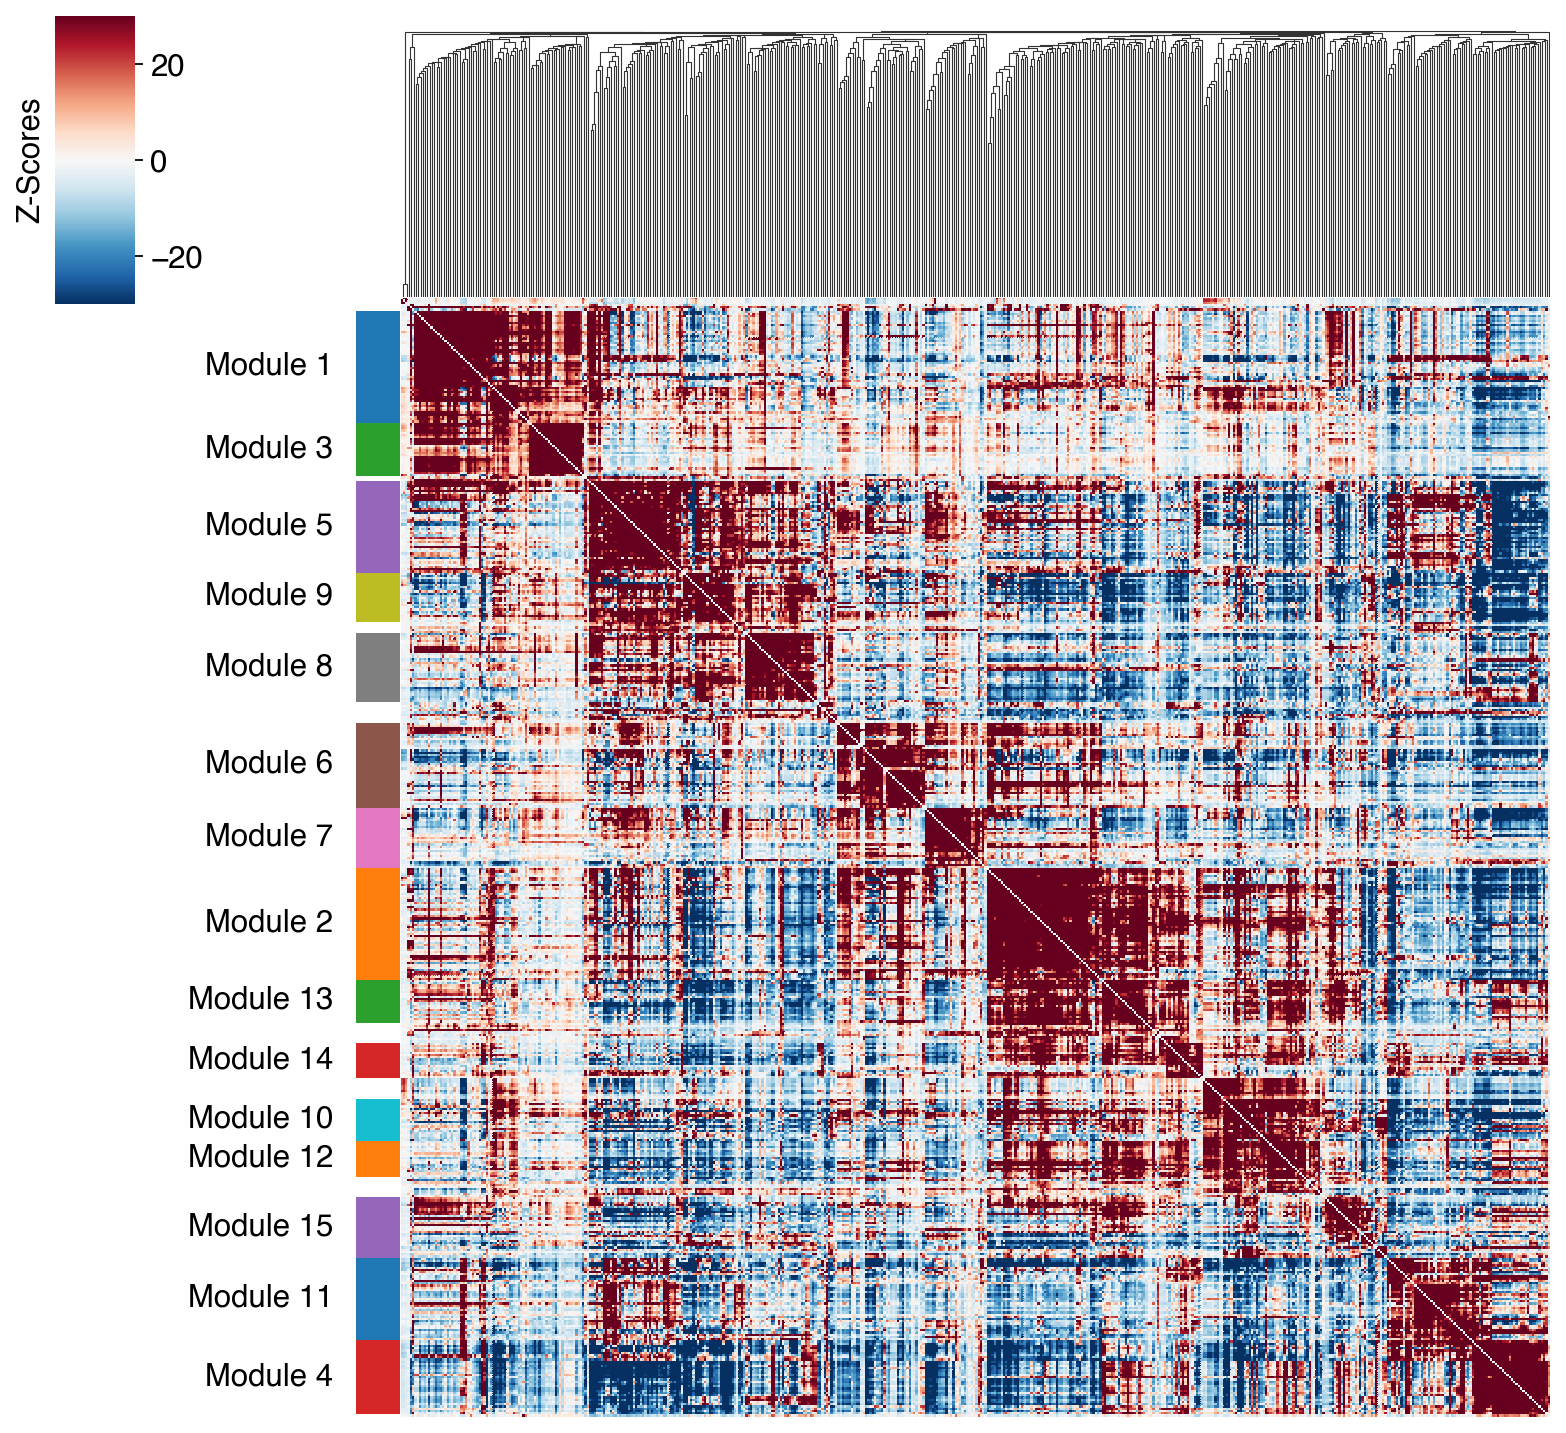

In [ ]:
hs.plot_local_correlations(vmin=-30, vmax=30)
plt.savefig('figures/myeloid_plot_local_correlations.pdf')
# In the manuscript, the number of the modules where arranged in order from top to bottom

In [ ]:
# Show the top genes for a module

module = 1

results = hs.results.join(hs.modules)
results.to_csv('data/myeloid_modules_hotspot_1000hvg.csv')

results = results.loc[results.Module == module]

results.sort_values('Z', ascending=False).head(10)

,C,Z,Pval,FDR,Module
Gene,,,,,
SPARC,0.592276,2089.637953,0.0,0.0,1.0
PLP1,0.516228,1788.856171,0.0,0.0,1.0
FABP7,0.355894,1501.488905,0.0,0.0,1.0
MARCKSL1,0.303194,1229.538411,0.0,0.0,1.0
APOD,0.319564,1155.484734,0.0,0.0,1.0
SEC61G,0.359155,1127.771633,0.0,0.0,1.0
KLF4,0.409749,1012.612677,0.0,0.0,1.0
OLIG1,0.290890,1012.160795,0.0,0.0,1.0
MT3,0.190260,949.692252,0.0,0.0,1.0


### Summary Module Scores

In [ ]:
module_scores = hs.calculate_module_scores()

module_scores.head()

  0%|          | 0/15 [00:00<?, ?it/s]

Computing scores for 15 modules...


100%|██████████| 15/15 [00:23<00:00,  1.60s/it]


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
PJ017_16,0.920209,8.073941,4.222088,-1.015657,0.828475,14.377386,-1.901933,-0.233656,-1.765031,0.275357,-1.731462,0.796561,0.363666,-0.577726,-0.284485
PJ017_40,3.050997,3.876595,1.665999,-0.297386,1.422294,-0.920604,-0.581685,0.088106,-1.360133,1.387651,-1.604920,0.939898,2.090619,-0.424295,0.433075
PJ017_46,-0.619575,-0.292686,-0.419781,0.937854,-0.788352,0.276931,-1.768676,-0.864740,-2.537963,-0.660928,-0.337953,-0.171120,1.599435,0.264837,1.255466
PJ017_59,0.147648,1.381608,0.207410,-0.072344,0.815091,1.172712,-2.193229,-0.451537,-2.496952,0.063712,-0.143383,0.235884,2.291827,0.027725,0.263791
PJ017_66,-0.251165,-0.023053,-0.281938,0.477399,-0.630655,1.886336,-2.136072,-0.712019,-2.557072,-0.782569,-1.266287,1.016454,3.661023,-0.337235,0.417354


In [ ]:
module_scores.to_csv('data/myeloid_modules_scores_hotspot.csv')